# Assignment Distilbert
#                         **Submitted by**,
#                                       Name : Bineeth Mathew
#                                       Student_Id :22004878
[github_link](https://github.com/Bineethmathew/amazon_polarity_aasignment)

[colab_link](https://colab.research.google.com/drive/1d_yVREPzZGW-a-jiaQMBqWb0kJPgOIHV?authuser=0#scrollTo=Rz4gv6c9_xAk)

# 1.0 INTRODUCTION

Thee Amazon Polarity Dataset, which contains over 35 million product reviews classified as positive or negative, provides valuable insights for businesses. Each review includes a rating indicating the customer’s sentiment towards the product. This labeled dataset is highly useful for natural language processing (NLP) and machine learning applications. Companies can leverage the dataset to refine their advertising and marketing strategies by analyzing customer feedback to understand which products are well-received and identifying key features that influence purchasing decisions. Such insights enable targeted marketing campaigns and improved product recommendations. Additionally, the dataset can be employed in recommendation systems to categorize products based on customer sentiment, thereby enhancing the organization and personalization of product recommendations.
In this task we will be training a Bert Large language model on amazon polarity reviews dataset. The dataset has each product  reviews over the years and each review has been classified as either negative or positive reviews.

In [1]:
# Install necessary libraries
!pip install  datasets
!pip install transformers
# Clear the output
from IPython.display import clear_output
clear_output()

In [2]:
# Import necessary libraries
import seaborn as sns
import warnings

import numpy as np
import pandas as pd
import plotly.express as px
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import tensorflow as tf
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

from transformers import TFAutoModelForSequenceClassification, create_optimizer
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.feature_extraction.text import CountVectorizer


from sklearn.metrics import confusion_matrix, classification_report

import ipywidgets as widgets




In [3]:
# Set seaborn theme
sns.set_theme()

# Ignore warnings
warnings.filterwarnings('ignore')

# 2.0 Methodology
 The BERT Large language model (Bidirectional Encoder Representations from Transformers) to classify reviews into positive or negative categories. BERT was pre-trained on extensive datasets, including Wikipedia and Google's BooksCorpus, which together encompass approximately 3 billion words. This extensive training has endowed BERT with a deep understanding of both the English language and general world knowledge (B. Muller 2022).

BERT utilizes an attention mechanism, a core component of transformer models, to comprehend the relationships between words in a sequence. This mechanism has significantly contributed to the success of transformer-based models in deep learning tasks, particularly in natural language processing (NLP). In this task, we employ BERT for sequence classification, which involves adding a multi-head attention layer to the base BERT model. Each attention head focuses on different patterns within the data. The architecture includes the base BERT model followed by a linear layer specifically designed for classifying sequences into predefined categories—in this case, positive and negative.

The model generates logits, which are raw prediction scores. To determine the final class, activation functions such as sigmoid or softmax are applied, depending on whether the classification is binary or multi-class. The model is compiled using the bert-base-uncased weights, which consist of 110 million parameters. The "uncased" designation means the model processes all text in lowercase, treating words such as "Bag" and "bag" or "America" and "america" as equivalent, thereby ignoring case sensitivity.

In [4]:
# read datadet

amazon = load_dataset("mteb/amazon_polarity")



Generating train split:   0%|          | 0/3600000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400000 [00:00<?, ? examples/s]

In [5]:
# Check the structure of the dataset
print(amazon)

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'label_text'],
        num_rows: 3600000
    })
    test: Dataset({
        features: ['label', 'text', 'label_text'],
        num_rows: 400000
    })
})


In [6]:
# Print the first example in the training set
print(amazon['train'][0])

# Check the keys in the dataset
print(amazon['train'].column_names)

{'label': 1, 'text': 'Stuning even for the non-gamer\n\nThis sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^', 'label_text': 'positive'}
['label', 'text', 'label_text']


In [7]:
# Shuffle the dataset and select a small sample
sample = amazon["train"].shuffle(seed=42).select(range(3))

# Loop through each row in the sample and print the text and corresponding sentiment label
for row in sample:
    print(f"\n'>>> text: {row['text']}'")
    print(f"'>>> sentiment_analysis: {row['label_text']}'")


'>>> text: Anyone who likes this better than the Pekinpah is a moron.

All the pretty people in this film. Even the Rudy character played by Michael Madsen. This is adapted from a Jim Thompson novel for cryin' out loud! These are supposed to be marginal characters, not fashion models. Though McQueen and McGraw were attractive (but check out McQueen's crummy prison haircut) they were believable in the role. Baldwin and Bassinger seem like movie stars trying to act like hard cases. Action wise, the robbery scene in the Pekinpah version was about 100 times more exciting and suspenseful than anything in this re-make.'
'>>> sentiment_analysis: negative'

'>>> text: Author seems mentally unstable

I know that Tom Robbins has a loyal following and I started the book with high expectations. However, I did not enjoy this book as it was too much work to follow his confused logic. I think that he was under the influence during most of time that he wrote.'
'>>> sentiment_analysis: negative'

'>>>

In [8]:
# Create a pandas DataFrame for the train for exploratory data analysis
train_df = pd.DataFrame({
    'review': amazon['train']['text'],
    'sentiment': amazon['train']['label']
})

# create a DataFrame for a subset of the dataset
reviews_subset = train_df.sample(n=10000, random_state=42)  # Example: Sample 10,000 rows

# Check if 'sentiment' and 'review' columns exist
print("Columns in DataFrame:", reviews_subset.columns)

# Ensure the DataFrame contains the required columns
if 'sentiment' in reviews_subset.columns and 'review' in reviews_subset.columns:
    print("DataFrame contains 'sentiment' and 'review' columns.")
else:
    print("DataFrame does not contain 'sentiment' and 'review' columns.")

Columns in DataFrame: Index(['review', 'sentiment'], dtype='object')
DataFrame contains 'sentiment' and 'review' columns.


In [9]:
# Create a training dataset by shuffling the 'train' split of the 'amazon' dataset
# and selecting the first 20,000 examples for training.
train_ds = amazon["train"].shuffle(seed=42).select(range(20000))

# Use the entire 'test' split of the 'amazon' dataset as the test dataset.
test_ds = amazon["test"].shuffle(seed=42).select(range(2000))

# 3.0 Explorartory data analysis
The code visualizes the distribution of word counts and text lengths in reviews based on sentiment. By generating histograms for positive and negative reviews, the functions help analyze the correlation between text characteristics and sentiment, offering insights into how review length and word count differ between sentiments. These visualizations facilitate easy comparison between positive and negative reviews.

In [10]:
def generate_word_cloud(df, sentiment_label):
    """
    Generate and display a word cloud for a specific sentiment label.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing 'sentiment' and 'review' columns.
    - sentiment_label (int): The sentiment label to filter by (e.g., 0 for negative, 1 for positive).

    Returns:
    - None: Displays the word cloud plot.
    """
    if 'sentiment' in df.columns and 'review' in df.columns:
        # Filter the DataFrame based on the sentiment label
        reviews_text = " ".join(df[df['sentiment'] == sentiment_label]['review'])

        # Generate the word cloud
        plt.figure(figsize=(10, 10))
        wc = WordCloud(max_words=2000, width=1600, height=800).generate(reviews_text)

        # Display the word cloud
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')  # Hide axis
        plt.title(f'Word Cloud for Sentiment {sentiment_label}')
        plt.show()
    else:
        print("DataFrame must contain 'sentiment' and 'review' columns.")

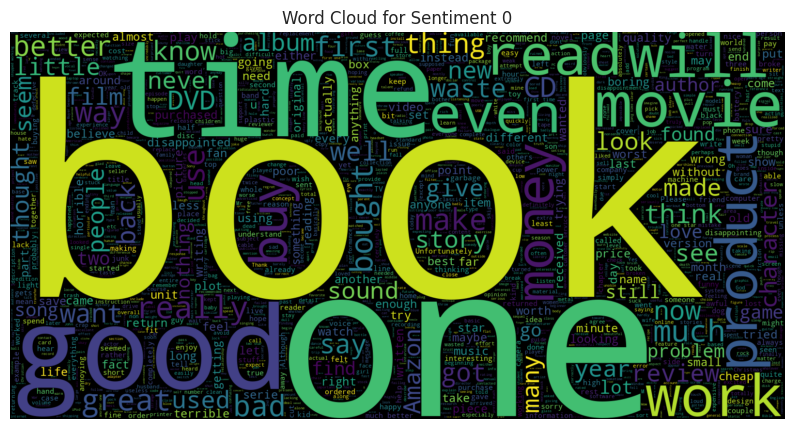

In [11]:
#function call for negative review
generate_word_cloud(reviews_subset, sentiment_label=0)  # For negative reviews


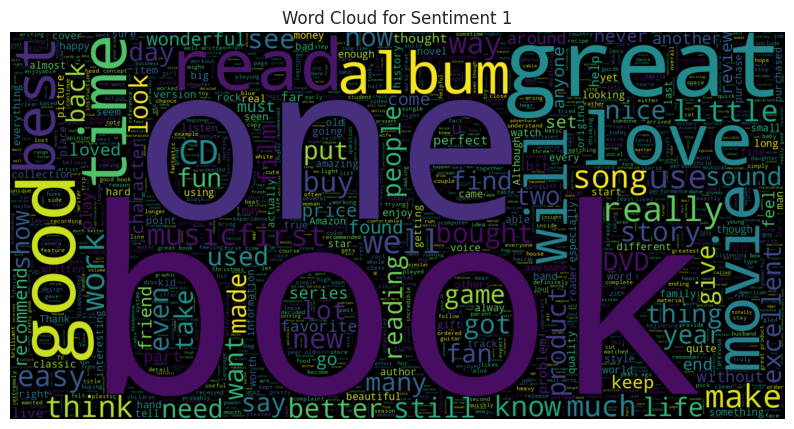

In [12]:
#function call for postive review
generate_word_cloud(reviews_subset, sentiment_label=1)  # For positive reviews

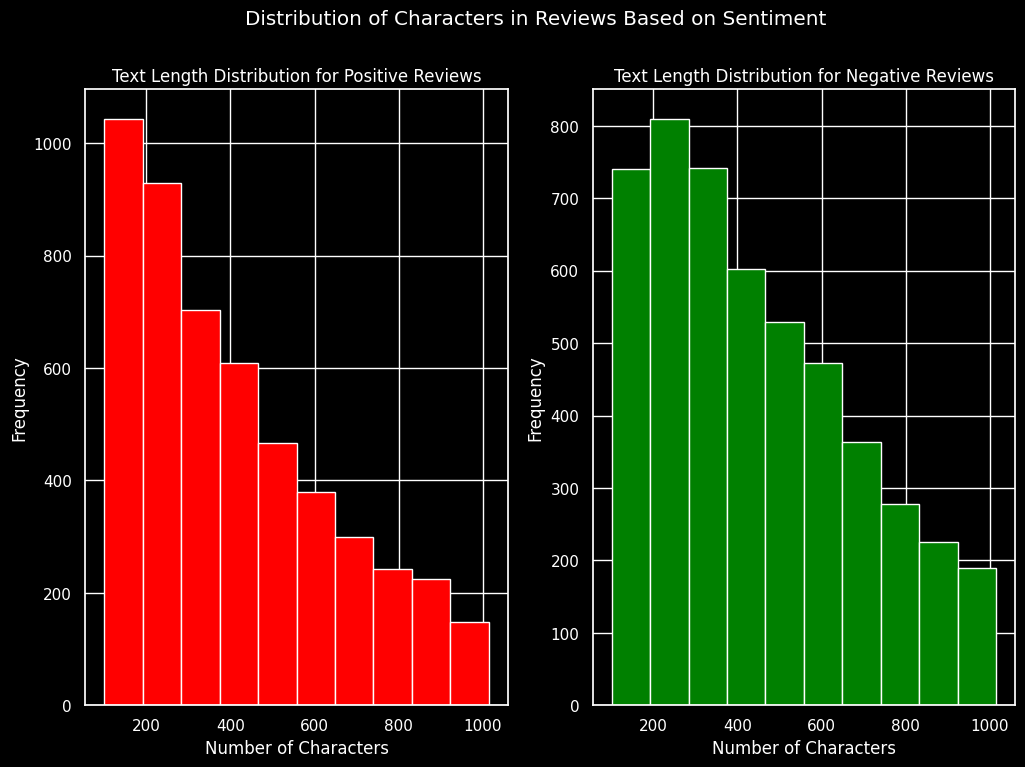

In [47]:
def plot_text_length_distribution(df):
    """
    Plot the distribution of text lengths for positive and negative reviews.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing 'sentiment' and 'review' columns.

    Returns:
    - None: Displays the histogram plots.
    """
    if 'sentiment' in df.columns and 'review' in df.columns:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

        # Length of reviews with positive sentiment
        text_len_positive = df[df['sentiment'] == 1]['review'].str.len()
        ax1.hist(text_len_positive, color='red')
        ax1.set_title('Text Length Distribution for Positive Reviews')
        ax1.set_xlabel('Number of Characters')
        ax1.set_ylabel('Frequency')

        # Length of reviews with negative sentiment
        text_len_negative = df[df['sentiment'] == 0]['review'].str.len()
        ax2.hist(text_len_negative, color='green')
        ax2.set_title('Text Length Distribution for Negative Reviews')
        ax2.set_xlabel('Number of Characters')
        ax2.set_ylabel('Frequency')

        fig.suptitle('Distribution of Characters in Reviews Based on Sentiment')
        plt.show()
    else:
        print("DataFrame must contain 'sentiment' and 'review' columns.")


# function call for distributin of character in review based on sentiment
plot_text_length_distribution(reviews_subset)


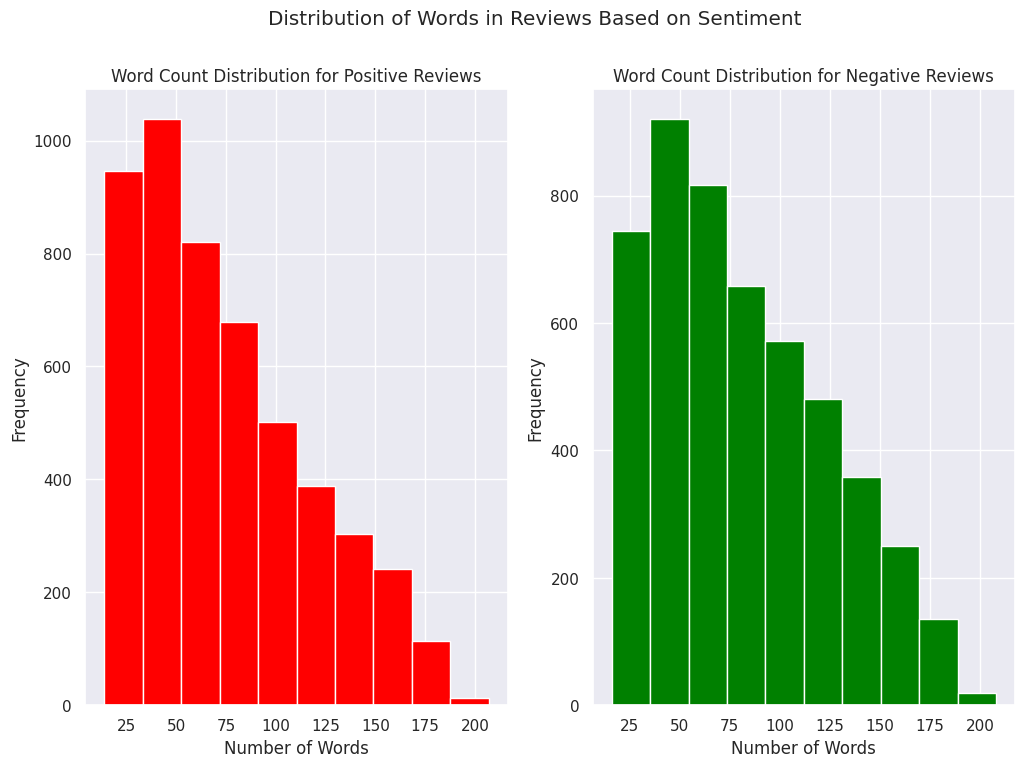

In [14]:
def plot_word_count_distribution(df):
    """
    Plot the distribution of word counts for positive and negative reviews.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing 'sentiment' and 'review' columns.

    Returns:
    - None: Displays the histogram plots.
    """
    if 'sentiment' in df.columns and 'review' in df.columns:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

        # Word count for reviews with positive sentiment
        word_count_positive = df[df['sentiment'] == 1]['review'].str.split().map(lambda x: len(x))
        ax1.hist(word_count_positive, color='red')
        ax1.set_title('Word Count Distribution for Positive Reviews')
        ax1.set_xlabel('Number of Words')
        ax1.set_ylabel('Frequency')

        # Word count for reviews with negative sentiment
        word_count_negative = df[df['sentiment'] == 0]['review'].str.split().map(lambda x: len(x))
        ax2.hist(word_count_negative, color='green')
        ax2.set_title('Word Count Distribution for Negative Reviews')
        ax2.set_xlabel('Number of Words')
        ax2.set_ylabel('Frequency')

        fig.suptitle('Distribution of Words in Reviews Based on Sentiment')
        plt.show()
    else:
        print("DataFrame must contain 'sentiment' and 'review' columns.")
# Function call for distribution of Words in Reviews Based on Sentiment
plot_word_count_distribution(reviews_subset)



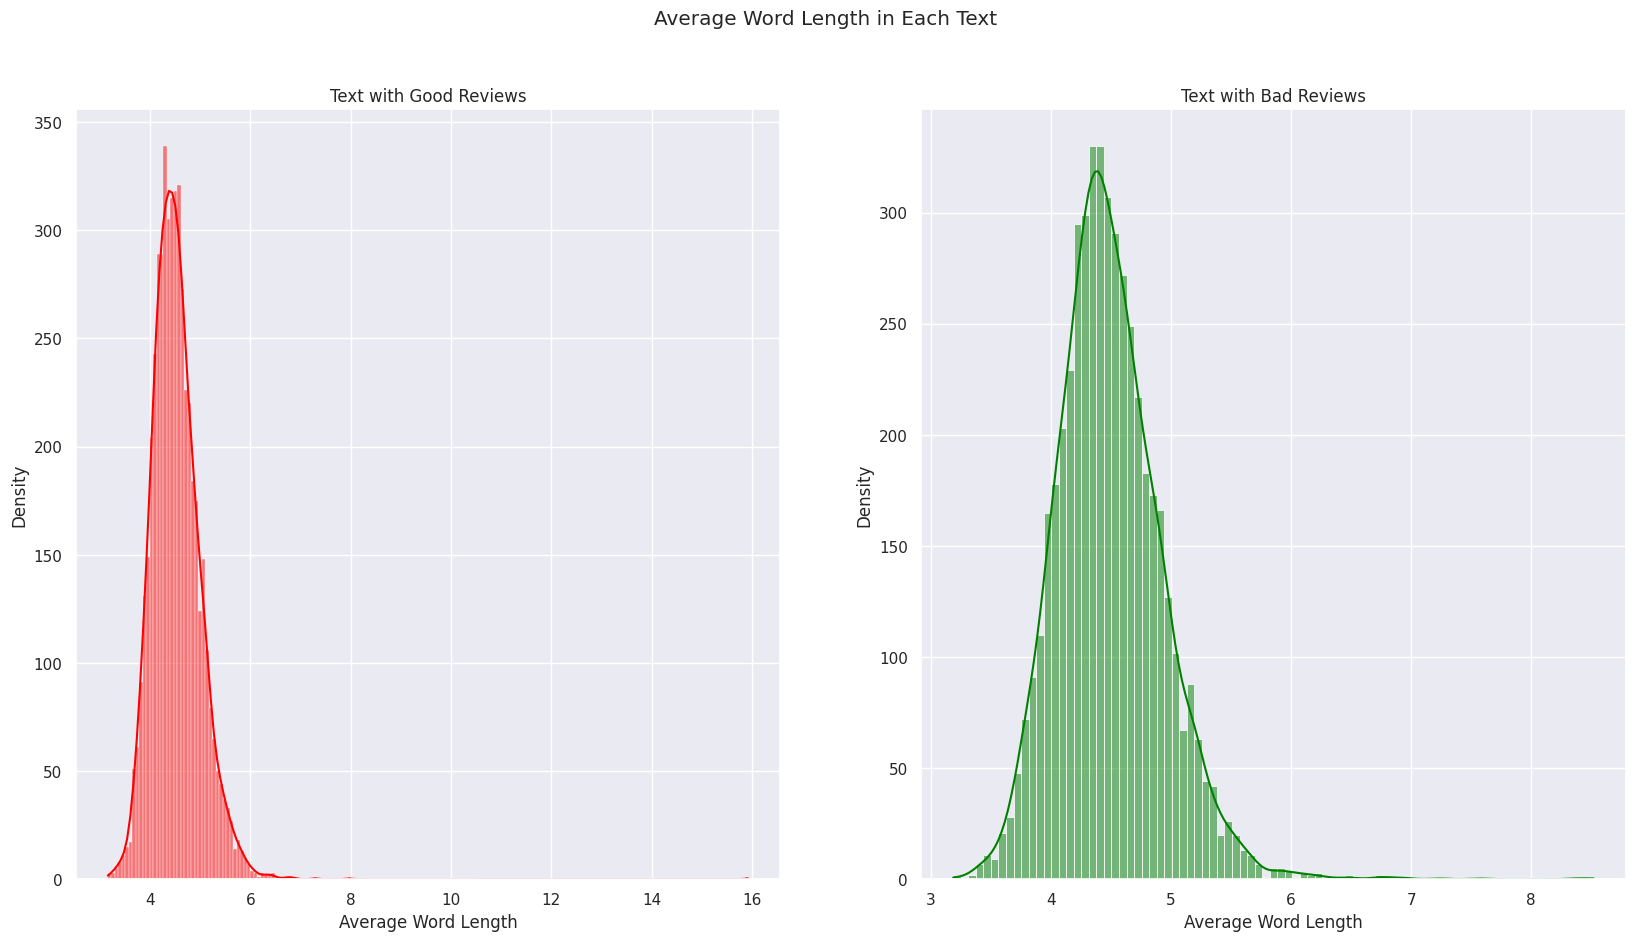

In [15]:
def plot_avg_word_length_distribution(df):
    """
    Plot the distribution of average word lengths for positive and negative reviews.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing 'sentiment' and 'review' columns.

    Returns:
    - None: Displays the histogram plots.
    """
    if 'sentiment' in df.columns and 'review' in df.columns:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

        # Average word length for positive sentiment reviews
        word_lengths_positive = df[df['sentiment'] == 1]['review'].str.split().apply(lambda x: [len(i) for i in x])
        avg_word_length_positive = word_lengths_positive.map(lambda x: np.mean(x))
        sns.histplot(avg_word_length_positive, ax=ax1, color='red', kde=True)
        ax1.set_title('Text with Good Reviews')
        ax1.set_xlabel('Average Word Length')
        ax1.set_ylabel('Density')

        # Average word length for negative sentiment reviews
        word_lengths_negative = df[df['sentiment'] == 0]['review'].str.split().apply(lambda x: [len(i) for i in x])
        avg_word_length_negative = word_lengths_negative.map(lambda x: np.mean(x))
        sns.histplot(avg_word_length_negative, ax=ax2, color='green', kde=True)
        ax2.set_title('Text with Bad Reviews')
        ax2.set_xlabel('Average Word Length')
        ax2.set_ylabel('Density')

        fig.suptitle('Average Word Length in Each Text')
        plt.show()
    else:
        print("DataFrame must contain 'sentiment' and 'review' columns.")


# Functin call for average word length in each text
plot_avg_word_length_distribution(reviews_subset)



In [16]:
#function get_corpus is designed to process a list of text strings (e.g., a column of reviews)
#and return a list of individual words from those strings
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(reviews_subset.review)
corpus[:5]

['Expensive', 'Junk', 'This', 'product', 'consists']

In [17]:
# most commonly used word in the dataset from train datset
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'the': 33321,
 'and': 20200,
 'I': 18906,
 'a': 18594,
 'to': 18555,
 'of': 15418,
 'is': 13201,
 'it': 10838,
 'this': 10382,
 'in': 8090}

In [18]:
def get_top_text_ngrams(corpus, n, g):
    # Initialize CountVectorizer to extract n-grams of size 'g'
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)

    # Transform the corpus into a bag-of-words model (matrix of token counts)
    bag_of_words = vec.transform(corpus)

    # Sum the occurrences of each n-gram across all documents in the corpus
    sum_words = bag_of_words.sum(axis=0)

    # Create a list of tuples where each tuple contains an n-gram and its corresponding frequency
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

    # Sort the list of n-grams by frequency in descending order
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    # Return the top 'n' most frequent n-grams
    return words_freq[:n]


In [19]:
# Get the top 20 most common unigrams (single words) from the 'review' column of reviews_subset
most_common_uni = get_top_text_ngrams(reviews_subset.review, 20, 1)

# Convert the list of tuples into a dictionary for easier manipulation
most_common_uni = dict(most_common_uni)

# Create a DataFrame to organize the common words and their counts
temp = pd.DataFrame(columns=["Common_words", 'Count'])
temp["Common_words"] = list(most_common_uni.keys())  # Assign the keys (words) to the 'Common_words' column
temp["Count"] = list(most_common_uni.values())       # Assign the values (counts) to the 'Count' column

# Create a horizontal bar plot using Plotly Express to visualize the most common words
fig = px.bar(temp, x="Count", y="Common_words", title='Common Words in Text', orientation='h',
             width=700, height=700, color='Common_words')

# Display the bar plot
fig.show()


In [20]:
def get_top_text_ngrams(corpus, n, ngram_range):
    """
    Extracts the top n most common n-grams from the corpus.

    Parameters:
    - corpus: list of strings (the text data).
    - n: int, the number of top n-grams to extract.
    - ngram_range: int, the range of n-grams (e.g., 2 for bigrams, 3 for trigrams).

    Returns:
    - most_common_ngrams: list of tuples containing the n-grams and their frequencies.
    """
    vectorizer = CountVectorizer(ngram_range=(ngram_range, ngram_range))
    X = vectorizer.fit_transform(corpus)
    ngrams = vectorizer.get_feature_names_out()
    ngram_counts = X.toarray().sum(axis=0)
    ngram_freq = dict(zip(ngrams, ngram_counts))
    most_common_ngrams = Counter(ngram_freq).most_common(n)

    return most_common_ngrams

def plot_top_ngrams(corpus, top_n=20):
    """
    Plots the top bigrams and trigrams from the text corpus.

    Parameters:
    - corpus: list of strings (the text data).
    - top_n: int, the number of top n-grams to plot.

    Returns:
    - None: Displays the bar plots for bigrams and trigrams.
    """
    # Plot top bigrams
    most_common_bi = get_top_text_ngrams(corpus, top_n, 2)
    most_common_bi = dict(most_common_bi)
    temp = pd.DataFrame(columns=["Common_words", "Count"])
    temp["Common_words"] = list(most_common_bi.keys())
    temp["Count"] = list(most_common_bi.values())

    fig = px.bar(temp, x="Count", y="Common_words", title='Common Bigrams in Text', orientation='h',
                 width=700, height=700, color='Common_words')
    fig.show()

    # Plot top trigrams
    most_common_tri = get_top_text_ngrams(corpus, top_n, 3)
    most_common_tri = dict(most_common_tri)
    temp = pd.DataFrame(columns=["Common_words", "Count"])
    temp["Common_words"] = list(most_common_tri.keys())
    temp["Count"] = list(most_common_tri.values())

    fig = px.bar(temp, x="Count", y="Common_words", title='Common Trigrams in Text', orientation='h',
                 width=700, height=700, color='Common_words')
    fig.show()


# Function call for common bigram in text
plot_top_ngrams(reviews_subset.review.tolist())



#  4.0 Data preprocessing

To prepare the data for training, the BERT tokenizer is initialized using the "bert-base-uncased" model. We first check the dataset for any missing or null values in the 'text' or 'label' fields. The tokenize_function is then defined to tokenize the input text, which includes encoding the text into input IDs and attention masks necessary for a transformer model. Additionally, if a fast tokenizer is used, word IDs are generated to map tokens back to their corresponding words in the original text. This function is applied to the entire training dataset using the map function for efficient processing. Finally, a DataCollatorWithPadding is initialized to dynamically pad the input sequences during training, ensuring they are properly formatted for the model's input requirements.

In [21]:
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [22]:
# Check for null or missing data in 'title' or 'label'
missing_title = sum([1 for x in train_ds['text'] if not x])
missing_labels = sum([1 for y in train_ds['label'] if y is None])

print(f"Missing title: {missing_title}")
print(f"Missing labels: {missing_labels}")

Missing title: 0
Missing labels: 0


In [23]:
def tokenize_function(examples):
    """
    Tokenizes the input text data and optionally adds word IDs if using a fast tokenizer.

    Args:
        examples (dict): A dictionary containing the input text under the key "text".

    Returns:
        dict: A dictionary containing tokenized outputs, including 'input_ids', 'attention_mask',
              and optionally 'word_ids' if using a fast tokenizer.

    Details:
        - The tokenizer encodes the input text into input IDs and attention masks,
          which are necessary for feeding data into a transformer model.
        - If the tokenizer is a "fast" tokenizer, it also computes word IDs for each token.
          These word IDs map tokens back to the original words in the input text,
          which can be useful for tasks that involve token-to-word alignment.
    """
    result = tokenizer(examples["text"], truncation=True, max_length=128)  # Tokenize the input text

    # If using a fast tokenizer, also generate word IDs
    if tokenizer.is_fast:
        result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]

    return result


In [24]:
# Apply the tokenize_function to the entire training dataset.
tokenized_datasets = train_ds.map(
    tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Dataset({
    features: ['label', 'text', 'label_text', 'input_ids', 'token_type_ids', 'attention_mask', 'word_ids'],
    num_rows: 20000
})

In [25]:
# tokenizer.model_max_length provides the maximum sequence length that the model can handle.
tokenizer.model_max_length

512

In [26]:
# Slicing produces a list of lists for each feature
tokenized_samples = tokenized_datasets[:3]

for idx, sample in enumerate(tokenized_samples["input_ids"]):
    print(f"'>>> Review {idx} length: {len(sample)}'")

'>>> Review 0 length: 128'
'>>> Review 1 length: 60'
'>>> Review 2 length: 63'


In [27]:
# Decode the tokenized input IDs back into human-readable text.
decoded_text = tokenizer.decode(tokenized_datasets[2]["input_ids"])


In [28]:
# Initialize a DataCollatorWithPadding to handle dynamic padding of input sequences.d
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors='tf')

In [29]:
train_size = len(tokenized_datasets)
 # Get the total number of examples in the tokenized dataset
print(train_size)

test_size = int(0.3 * train_size)
# Calculate the size of the test set as 30% of the total dataset size

downsampled_dataset = tokenized_datasets.train_test_split(
    test_size=test_size,  # Split the dataset into training and test sets using the calculated test size
    seed=42  # Set the seed for reproducibility of the split
)


20000


In [30]:
# create hugging face token
from huggingface_hub import notebook_login

notebook_login()

In [31]:
# Define the batch size for the dataset
BATCH_SIZE = 16

# Convert the 'train' split of the downsampled dataset to a TensorFlow dataset for training
train_dataset = downsampled_dataset["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],  # Specify the columns to use as features
    label_cols=["labels"],  # Specify the column to use as labels
    shuffle=True,  # Shuffle the dataset to ensure randomization of data batches
    collate_fn=data_collator,  # Use the specified collate function to process batches
    batch_size=BATCH_SIZE,  # Set the batch size for training
)

# Convert the 'test' split of the downsampled dataset to a TensorFlow dataset for validation
validation_dataset = downsampled_dataset["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],  # Specify the columns to use as features
    label_cols=["labels"],  # Specify the column to use as labels
    shuffle=True,  # Shuffle the dataset to ensure randomization of data batches
    collate_fn=data_collator,  # Use the specified collate function to process batches
    batch_size=BATCH_SIZE,  # Set the batch size for validation
)


# 5.0 Training and Fine Tuning
The tokenized dataset was first divided into training and test sets, with 30% allocated to the test set. From the training portion, 20,000 examples from the Amazon dataset were selected after shuffling to create the final training dataset. The model was trained for five epochs, and the total number of training steps was determined based on the size of the training dataset and the number of epochs. A specialized optimizer and learning rate schedule were designed, including a very low initial learning rate of 1e-6, no warmup steps, and a weight decay rate of 0.01 to mitigate overfitting. The model was compiled with sparse categorical cross-entropy as the loss function and accuracy as the performance metric. Throughout training, the model achieved a training accuracy of approximately 93.28% and a validation accuracy of 92.16%, reflecting strong performance on both datasets. The training, conducted on a V100 GPU, was efficient, with each epoch taking around seven minutes, which is effective given the extensive dataset and the complexity of the BERT model.


In [32]:
# Define the model checkpoint identifier for the BERT model
model_checkpoint = "bert-base-uncased"

In [33]:
# Load a pre-trained BERT model for sequence classification with TensorFlow
model = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
# display model summary
model.summary()


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
# Set the number of training epochs
num_epochs = 5
# Calculate the total number of training steps
num_train_steps = len(train_dataset) * num_epochs

import tensorflow as tf
from transformers import create_optimizer
# Create an optimizer and learning rate schedule
optimizer, schedule = create_optimizer(
    init_lr=1e-6,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
)

# Compile the model
model.compile(optimizer=optimizer,
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"],
              )

In [36]:
# Fit the model
history=model.fit(
    train_dataset,  # Assuming train_dataset is your input data
    epochs=num_epochs,
    validation_data=validation_dataset  # Include this if you have validation data
)

Epoch 1/5
875/875 [==============================] - 488s 525ms/step - loss: 0.4388 - accuracy: 0.8049 - val_loss: 0.2492 - val_accuracy: 0.9145
Epoch 2/5
875/875 [==============================] - 462s 528ms/step - loss: 0.2408 - accuracy: 0.9157 - val_loss: 0.2131 - val_accuracy: 0.9230
Epoch 3/5
875/875 [==============================] - 461s 527ms/step - loss: 0.2085 - accuracy: 0.9281 - val_loss: 0.2008 - val_accuracy: 0.9278
Epoch 4/5
875/875 [==============================] - 462s 528ms/step - loss: 0.1903 - accuracy: 0.9364 - val_loss: 0.1957 - val_accuracy: 0.9287
Epoch 5/5
875/875 [==============================] - 462s 528ms/step - loss: 0.1853 - accuracy: 0.9379 - val_loss: 0.1942 - val_accuracy: 0.9295


In [37]:
# save the trained model to google drive
model.save('/content/drive/MyDrive/llms/llms_best_model')

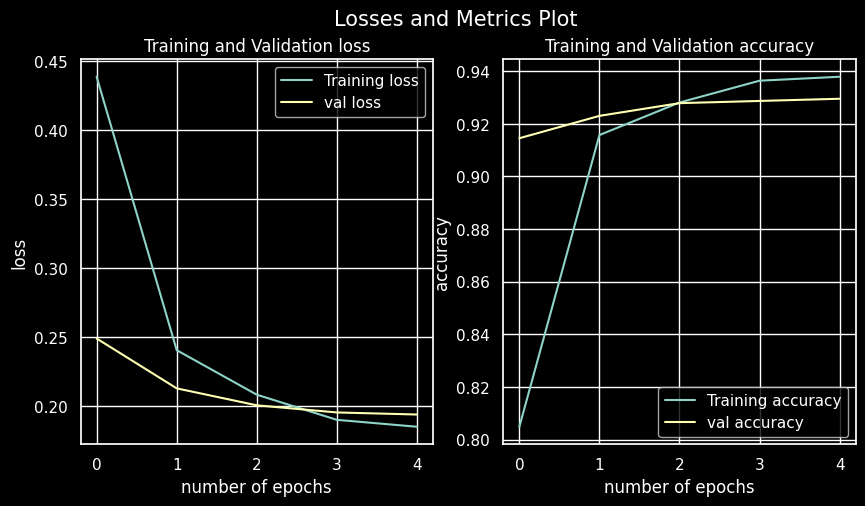

In [38]:
# get loss from training history
loss = history.history['loss']

#get accuracy for train history
accuracy = history.history['accuracy']

# get val_loss from training history
val_loss = history.history['val_loss']

# get val_accuracy from training history
val_accuracy = history.history['val_accuracy']

# get epochs from training history
epochs_range = range(len(loss))

#plot result
plt.style.use("dark_background") # set background to black
plt.figure(figsize=(10,5)) # set figure size
plt.suptitle("Losses and Metrics Plot", fontsize=15)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training loss') #plot
plt.plot(epochs_range, val_loss, label='val loss')# plot
plt.xlabel('number of epochs') #set x axis label for plot 1
plt.ylabel('loss') #set y axis label for plot 1
plt.legend(loc='upper right') # set legend
plt.title('Training and Validation loss') # set title
plt.subplot(1, 2, 2)
plt.plot(epochs_range, accuracy, label='Training accuracy') # plot
plt.plot(epochs_range, val_accuracy, label='val accuracy') # plot
plt.xlabel('number of epochs') #set x axis label for plot 2
plt.ylabel('accuracy') #set y axis label for plot 2
plt.legend(loc='lower right') # set legend
plt.title('Training and Validation accuracy') # set title for plot
plt.show() # show figure

#  6.0 DEPLOYMENT

After training, the model was saved to a directory on Google Drive for easy access during deployment. For deployment, the model was integrated with a user interface using the ipywidgets library. This setup allows users to input text through an interactive text box and then click a "predict" button to submit the text. Once submitted, the text is tokenized using the bert-base-uncased tokenizer. The tokenized input is then fed into the trained model for prediction. The model's output is in the form of logits, which are raw prediction scores. To determine the predicted class, we use np.argmax to select the class with the highest probability. Additionally, the model returns the probability that the input text belongs to each class, providing further insight into the classification

In [46]:
# load saved trained model
model = tf.keras.models.load_model("/content/drive/MyDrive/llms/llms_best_model.")

In [45]:
# initiate tokenizer

tokenizer.from_pretrained('distilbert-base-uncased')

def predict(text):
    """
    Predicts the class label for a given text.

    Args:
        text (str): The input text to classify.

    Returns:
        predicted_class (int): Predicted class label (0 or 1).
        predicted_probability (float): Predicted probability.
    """
    # Tokenize input text
    inputs = tokenizer(text, return_tensors="tf", truncation=True, padding=True,
                       max_length=128)

    # Model prediction
    prediction = model(inputs)
    logits = prediction['logits'].numpy()

    # Convert logits to probabilities
    probabilities = tf.nn.softmax(logits, axis=1).numpy()[0]

    # Get the predicted class and its probability
    predicted_class = np.argmax(probabilities)
    predicted_probability = probabilities[predicted_class]

    return predicted_class, predicted_probability

def on_button_click(button):
    """
    Callback function called when the button is pressed.

    Args:
        button: The button widget.
    """
    # Clear the previous output from the display.
    clear_output(wait=True)

    # Call the `predict` function
    prediction, probability = predict(text_area.value)

    # Display the prediction
    if prediction == 1:
        print(f"Prediction: postive with probability {probability:.4f}%")
    else:
        print(f"Prediction: Negative c with probability {probability:.4f}")

    # Redisplay the user interface
    display_ui()

def display_ui():
    """
    Displays the text area and button widgets.
    """
    display(text_area, button)

import ipywidgets as widgets
from IPython.display import display, clear_output

# Create a text area widget
text_area = widgets.Textarea(
    value='',
    placeholder='Type something',
    description='Input Text:',
    disabled=False,
    layout=widgets.Layout(height='100px', width='80%')
)

# Create a button widget
button = widgets.Button(description="Predict")
button.on_click(on_button_click)

# Initially display the user interface
display_ui()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizerFast'.


Textarea(value='', description='Input Text:', layout=Layout(height='100px', width='80%'), placeholder='Type so…

Button(description='Predict', style=ButtonStyle())

# 7.0 Conclusion
While the model demonstrates impressive predictive performance on the dataset, fine-tuning the pre-trained BERT model for our specific task still demands significant computational resources. For example, completing a single epoch on a V100 GPU takes around 10 minutes. This level of computing power is not typically available on a standard PC, making the process of fine-tuning a BERT model for natural language processing tasks both resource-intensive and time-consuming. Consequently, deploying such models on limited hardware may pose challenges for accessibility and efficiency.








# 8.0 Refernce
8.1    [hugging face](https://huggingface.co/learn/nlp-course/chapter7/3?fw=pt)

8.2 [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://www.researchgate.net/publication/328230984_BERT_Pre-training_of_Deep_Bidirectional_Transformers_for_Language_Understanding)

8.3 https://medium.com/@UnnatiKdm/predicting-sentiment-polarity-for-amazon-product-reviews-dataset-blog-1-c2f79bc82e5d

8.4 [dataset](https://huggingface.co/datasets/mteb/amazon_polarity)

8.5[ B Muller (2022) ‘Bert 101 state of the art NLP model explained](https://huggingface.co/blog/bert-101)

